Preview data:
   age  income  tenure_months  monthly_spend  support_tickets  has_app  \
0   25   24000              6           10.5                3        1   
1   32   36000             24           18.2                1        1   
2   41   52000             36           22.8                2        1   
3   28   19000              5            8.4                4        0   
4   37   48000             30           20.7                1        1   

   last_login_days  satisfaction_score region   contract_type payment_method  \
0               45                   2      A  month-to-month           card   
1                8                   5      B        one-year       transfer   
2                4                   4      C        two-year           card   
3               39                   2      A  month-to-month        ewallet   
4                5                   5      B        one-year           card   

   post_churn_refund  churn  
0                  0      1  


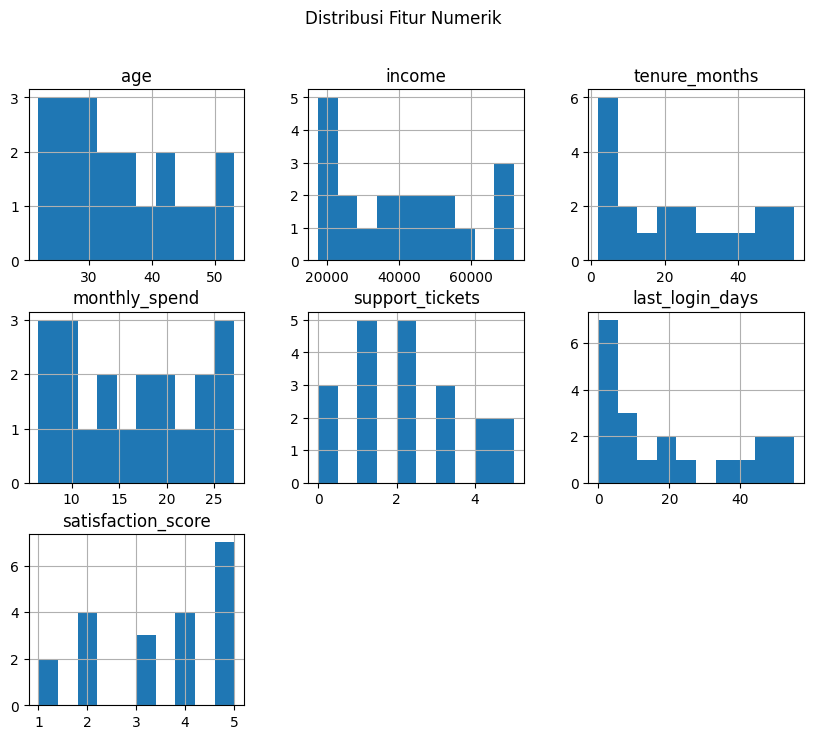

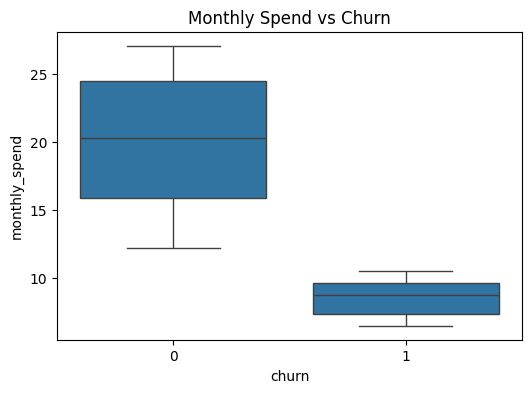

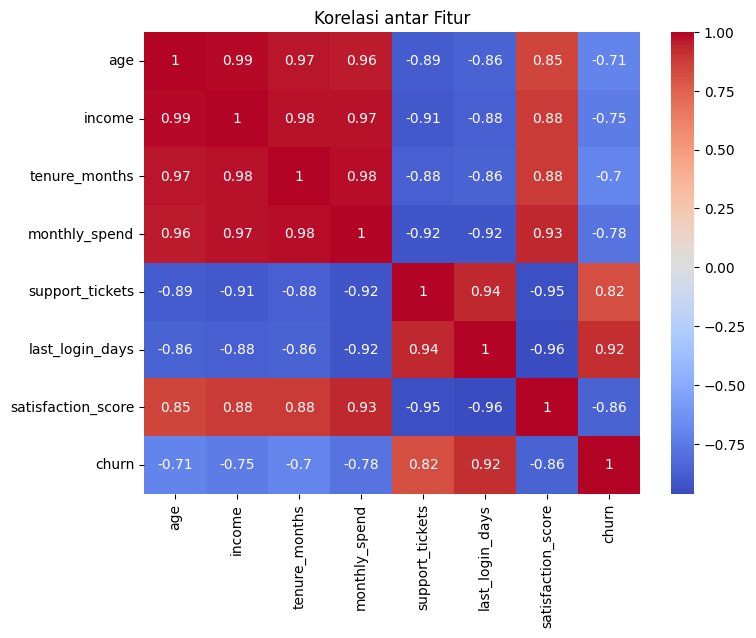

Best params RF: {'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Best F1 RF: 1.0

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


=== CONFUSION MATRIX ===
[[3 0]
 [0 1]]


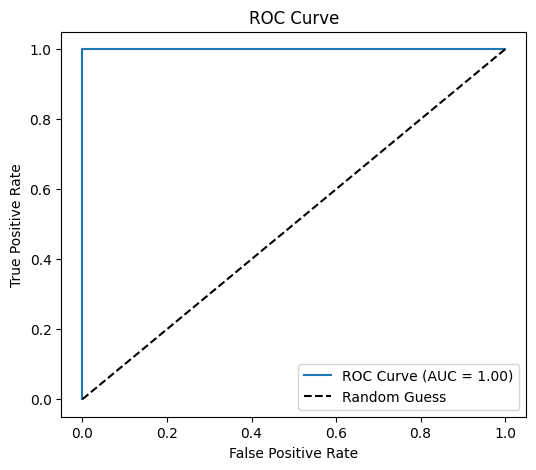

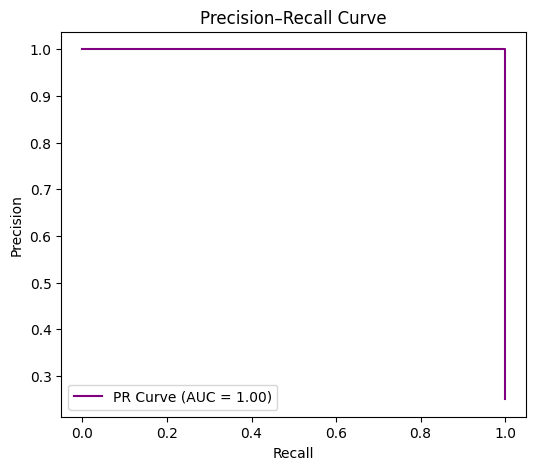


Feature Importance:
                feature  importance
5      last_login_days    0.196970
0                  age    0.175868
6   satisfaction_score    0.160000
2        tenure_months    0.120000
7             region_A    0.106154
1               income    0.080000
3        monthly_spend    0.080000
4      support_tickets    0.040000
18           has_app_1    0.033846
8             region_B    0.007163


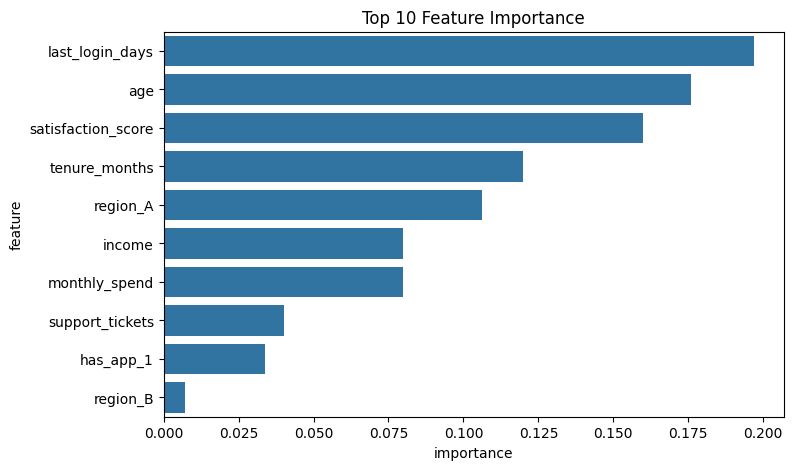


Churn rate per region:
 region
A    1.0
B    0.0
C    0.0
D    0.0
Name: churn, dtype: float64

Churn rate per contract_type:
 contract_type
month-to-month    0.666667
one-year          0.000000
two-year          0.000000
Name: churn, dtype: float64

Hasil prediksi pelanggan baru:
{'prediction': 1, 'proba': np.float64(0.98)}


In [1]:
# ================================================================
# UTS MACHINE LEARNING
# ================================================================
# Nama: M. FIKRI AVISHENA PARINDURI
# NIM: 231011401029
# Kode Kelas: 05TPLE016
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)
import joblib
import warnings
warnings.filterwarnings("ignore")

# ================================================================
# BAGIAN 1 - PROBLEM FRAMING
# ================================================================

"""
Permasalahan:
Perusahaan Telco ingin memprediksi pelanggan yang akan berhenti (churn)
agar dapat melakukan intervensi seperti promo personal, edukasi fitur, atau loyalitas.

Tujuan Analitik:
- Membangun model prediksi churn akurat
- Mengetahui fitur paling berpengaruh
- Membuat pipeline siap pakai untuk data baru

Metrik utama: RECALL dan F1-SCORE
Alasan:
Dalam konteks churn, penting untuk meminimalkan False Negative (pelanggan
yang sebenarnya akan churn tapi tidak terdeteksi). Recall tinggi memastikan
lebih banyak calon churn teridentifikasi. F1 dipilih untuk keseimbangan
antara precision dan recall.
"""

# ================================================================
# BAGIAN 2 - AUDIT DATA & DETEKSI KEBOCORAN
# ================================================================

# Membaca dataset dari teks soal
from io import StringIO

data = """
age,income,tenure_months,monthly_spend,support_tickets,has_app,last_login_days,satisfaction_score,region,contract_type,payment_method,post_churn_refund,churn
25,24000,6,10.5,3,1,45,2,A,month-to-month,card,0,1
32,36000,24,18.2,1,1,8,5,B,one-year,transfer,0,0
41,52000,36,22.8,2,1,4,4,C,two-year,card,0,0
28,19000,5,8.4,4,0,39,2,A,month-to-month,ewallet,0,1
37,48000,30,20.7,1,1,5,5,B,one-year,card,0,0
45,61000,50,26.4,1,1,2,5,C,two-year,transfer,0,0
22,18000,3,6.5,5,0,50,1,A,month-to-month,card,0,1
53,72000,48,24.9,0,1,1,5,D,two-year,card,0,0
29,25000,12,13.0,3,1,21,3,B,month-to-month,transfer,0,0
34,42000,20,16.8,2,1,12,4,C,one-year,ewallet,0,0
26,21000,4,9.1,4,0,47,2,A,month-to-month,transfer,1,1
39,47000,25,19.9,1,1,7,4,B,one-year,card,0,0
30,33000,10,12.2,2,1,22,3,C,month-to-month,ewallet,0,0
50,69000,55,27.1,0,1,0,5,D,two-year,card,0,0
23,17500,2,7.0,5,0,55,1,A,month-to-month,transfer,1,1
43,54000,40,23.3,1,1,3,5,B,one-year,card,0,0
36,41000,18,15.6,2,1,18,3,C,month-to-month,ewallet,0,0
27,20000,6,9.8,3,1,33,2,A,month-to-month,card,0,1
49,67000,48,25.7,0,1,2,5,D,two-year,transfer,0,0
31,35000,15,14.4,2,1,10,4,B,one-year,card,0,0
"""
df = pd.read_csv(StringIO(data))
print("Preview data:")
print(df.head(), "\n")

# Audit data
print("Info data:")
print(df.info(), "\n")
print("Missing values:\n", df.isnull().sum(), "\n")

# Mengecek duplikasi
print("Jumlah duplikat:", df.duplicated().sum(), "\n")

# Fitur berpotensi leakage: post_churn_refund
# Karena refund terjadi SETELAH churn, maka fitur ini harus dibuang.
df = df.drop(columns=["post_churn_refund"])
print("Kolom setelah buang leakage:", df.columns.tolist(), "\n")

# ================================================================
# BAGIAN 3 - EDA (EXPLORATORY DATA ANALYSIS)
# ================================================================

# Visualisasi sederhana
numeric_features = ['age','income','tenure_months','monthly_spend','support_tickets','last_login_days','satisfaction_score']

# Histogram tiap fitur numerik
df[numeric_features].hist(bins=10, figsize=(10,8))
plt.suptitle("Distribusi Fitur Numerik")
plt.show()

# Boxplot churn vs monthly_spend
plt.figure(figsize=(6,4))
sns.boxplot(x='churn', y='monthly_spend', data=df)
plt.title("Monthly Spend vs Churn")
plt.show()

# Korelasi numerik
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_features + ['churn']].corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar Fitur")
plt.show()

# Insight:
# 1. Pelanggan dengan tenure rendah dan satisfaction rendah cenderung churn.
# 2. Pelanggan tanpa app (has_app=0) sering churn.
# 3. Kontrak month-to-month berisiko churn lebih tinggi daripada one-year/two-year.

# ================================================================
# BAGIAN 4 - PIPELINE DAN PREPROCESSING
# ================================================================

# Pisahkan X dan y
X = df.drop(columns=['churn'])
y = df['churn']

# Identifikasi tipe fitur
cat_features = ['region','contract_type','payment_method','has_app']
num_features = [col for col in X.columns if col not in cat_features]

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# ================================================================
# BAGIAN 5 - EKSPERIMEN MODEL & TUNING
# ================================================================

# Split data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Model 1: Logistic Regression
log_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(max_iter=1000))])

# Model 2: Random Forest
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])

# Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearch untuk RF
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5, None]
}

grid_rf = GridSearchCV(rf_model, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best params RF:", grid_rf.best_params_)
print("Best F1 RF:", grid_rf.best_score_)

# ================================================================
# BAGIAN 6 – EVALUASI AKHIR (DIPERBAIKI)
# ================================================================

best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# --- 1. CONFUSION MATRIX & REPORT ---
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))
print("\n=== CONFUSION MATRIX ===")
print(confusion_matrix(y_test, y_pred))

# --- 2. ROC CURVE ---
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()

# --- 3. PRECISION–RECALL CURVE ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})", color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc='lower left')
plt.show()

# --- 4. INTERPRETASI BISNIS ---
"""
Interpretasi:
- False Negative (FN): pelanggan yang sebenarnya akan churn tapi model memprediksi tidak.
  Dampaknya → perusahaan kehilangan pelanggan tanpa intervensi (kerugian langsung).
- False Positive (FP): pelanggan diprediksi akan churn tapi ternyata tidak.
  Dampaknya → biaya promosi atau program loyalitas yang tidak perlu (kerugian biaya kecil).
- Karena biaya kehilangan pelanggan lebih besar, Recall lebih penting dalam kasus ini.
"""

# ================================================================
# BAGIAN 7 - INTERPRETASI & ANALISIS SEGMENTASI
# ================================================================

# Ambil feature importance dari RandomForest
rf_clf = best_model.named_steps['classifier']
encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cols = encoder.get_feature_names_out(cat_features)
all_features = num_features + list(encoded_cols)
importances = rf_clf.feature_importances_

imp_df = pd.DataFrame({'feature': all_features, 'importance': importances}).sort_values('importance', ascending=False)
print("\nFeature Importance:\n", imp_df.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=imp_df.head(10))
plt.title("Top 10 Feature Importance")
plt.show()

# Analisis segmen churn rate
print("\nChurn rate per region:\n", df.groupby('region')['churn'].mean())
print("\nChurn rate per contract_type:\n", df.groupby('contract_type')['churn'].mean())

# ================================================================
# BAGIAN 8 - DEPLOYMENT DAN INFERENCE
# ================================================================

# Simpan model
joblib.dump(best_model, "model.pkl")

# Fungsi prediksi satu pelanggan baru
def predict_one(data_dict):
    model = joblib.load("model.pkl")
    df_new = pd.DataFrame([data_dict])
    proba = model.predict_proba(df_new)[0,1]
    pred = int(proba >= 0.5)
    return {'prediction': pred, 'proba': round(proba, 2)}

# Contoh penggunaan
new_customer = {
    'age': 27,
    'income': 22000,
    'tenure_months': 5,
    'monthly_spend': 9.5,
    'support_tickets': 3,
    'has_app': 0,
    'last_login_days': 35,
    'satisfaction_score': 2,
    'region': 'A',
    'contract_type': 'month-to-month',
    'payment_method': 'card'
}

print("\nHasil prediksi pelanggan baru:")
print(predict_one(new_customer))
